<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:08:55] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


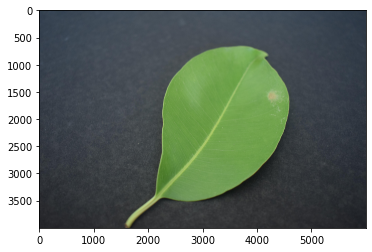

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

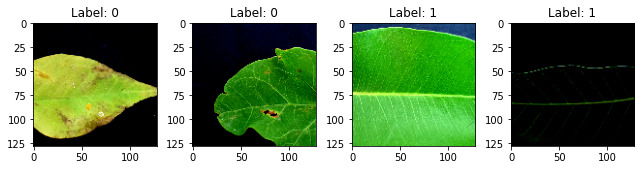

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:01] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:03] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2609207240779923 samples/sec                   batch loss = 0.8904430866241455 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.267214066083868 samples/sec                   batch loss = 1.2899888753890991 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.2273205034868124 samples/sec                   batch loss = 0.9910556674003601 | accuracy = 0.4


Epoch[1] Batch[20] Speed: 1.2649508181963287 samples/sec                   batch loss = 1.0531975030899048 | accuracy = 0.4125


Epoch[1] Batch[25] Speed: 1.2648342826064947 samples/sec                   batch loss = 1.0930042266845703 | accuracy = 0.41


Epoch[1] Batch[30] Speed: 1.2655068034163794 samples/sec                   batch loss = 0.6648955345153809 | accuracy = 0.425


Epoch[1] Batch[35] Speed: 1.2658710777798612 samples/sec                   batch loss = 0.9641295671463013 | accuracy = 0.45


Epoch[1] Batch[40] Speed: 1.2726495825691806 samples/sec                   batch loss = 0.4739225208759308 | accuracy = 0.48125


Epoch[1] Batch[45] Speed: 1.2650372324234136 samples/sec                   batch loss = 0.4880410432815552 | accuracy = 0.5


Epoch[1] Batch[50] Speed: 1.2646356875490805 samples/sec                   batch loss = 0.4591182470321655 | accuracy = 0.51


Epoch[1] Batch[55] Speed: 1.2642051516996509 samples/sec                   batch loss = 0.5310848951339722 | accuracy = 0.5181818181818182


Epoch[1] Batch[60] Speed: 1.2724941755527868 samples/sec                   batch loss = 0.5840648412704468 | accuracy = 0.5375


Epoch[1] Batch[65] Speed: 1.2708613210985185 samples/sec                   batch loss = 0.9244283437728882 | accuracy = 0.5423076923076923


Epoch[1] Batch[70] Speed: 1.276080398799464 samples/sec                   batch loss = 0.5651283860206604 | accuracy = 0.55


Epoch[1] Batch[75] Speed: 1.266742557992724 samples/sec                   batch loss = 0.728543758392334 | accuracy = 0.55


Epoch[1] Batch[80] Speed: 1.2693525923603466 samples/sec                   batch loss = 0.7969669699668884 | accuracy = 0.540625


Epoch[1] Batch[85] Speed: 1.271292742661518 samples/sec                   batch loss = 0.43869853019714355 | accuracy = 0.5529411764705883


Epoch[1] Batch[90] Speed: 1.270487146072184 samples/sec                   batch loss = 0.7156396508216858 | accuracy = 0.55


Epoch[1] Batch[95] Speed: 1.2701499230023634 samples/sec                   batch loss = 0.5535203218460083 | accuracy = 0.5552631578947368


Epoch[1] Batch[100] Speed: 1.269169953716781 samples/sec                   batch loss = 0.5059465169906616 | accuracy = 0.555


Epoch[1] Batch[105] Speed: 1.26824403038334 samples/sec                   batch loss = 0.7187092900276184 | accuracy = 0.5666666666666667


Epoch[1] Batch[110] Speed: 1.2668162080013399 samples/sec                   batch loss = 0.9842132925987244 | accuracy = 0.5727272727272728


Epoch[1] Batch[115] Speed: 1.2685479173307863 samples/sec                   batch loss = 0.5696558952331543 | accuracy = 0.5782608695652174


Epoch[1] Batch[120] Speed: 1.2668805870360753 samples/sec                   batch loss = 1.70916748046875 | accuracy = 0.5833333333333334


Epoch[1] Batch[125] Speed: 1.26712878974407 samples/sec                   batch loss = 0.7084684371948242 | accuracy = 0.582


Epoch[1] Batch[130] Speed: 1.2639319069124666 samples/sec                   batch loss = 0.31165045499801636 | accuracy = 0.5903846153846154


Epoch[1] Batch[135] Speed: 1.2692305393649692 samples/sec                   batch loss = 0.18193930387496948 | accuracy = 0.5925925925925926


Epoch[1] Batch[140] Speed: 1.2745672969250026 samples/sec                   batch loss = 0.6026722192764282 | accuracy = 0.5964285714285714


Epoch[1] Batch[145] Speed: 1.271175517248956 samples/sec                   batch loss = 0.38767415285110474 | accuracy = 0.6


Epoch[1] Batch[150] Speed: 1.2651699289034481 samples/sec                   batch loss = 0.34592801332473755 | accuracy = 0.6033333333333334


Epoch[1] Batch[155] Speed: 1.2717290843357694 samples/sec                   batch loss = 0.38534510135650635 | accuracy = 0.6


Epoch[1] Batch[160] Speed: 1.2702552258703828 samples/sec                   batch loss = 0.2696298658847809 | accuracy = 0.60625


Epoch[1] Batch[165] Speed: 1.2663380183035078 samples/sec                   batch loss = 0.6520878076553345 | accuracy = 0.6090909090909091


Epoch[1] Batch[170] Speed: 1.2651739359878644 samples/sec                   batch loss = 0.40770238637924194 | accuracy = 0.6088235294117647


Epoch[1] Batch[175] Speed: 1.2708646904446175 samples/sec                   batch loss = 0.6382238864898682 | accuracy = 0.6128571428571429


Epoch[1] Batch[180] Speed: 1.2766808946102342 samples/sec                   batch loss = 0.4300518333911896 | accuracy = 0.6180555555555556


Epoch[1] Batch[185] Speed: 1.2668253909405143 samples/sec                   batch loss = 0.6889757513999939 | accuracy = 0.6135135135135135


Epoch[1] Batch[190] Speed: 1.2686845173026466 samples/sec                   batch loss = 0.5730679631233215 | accuracy = 0.6105263157894737


Epoch[1] Batch[195] Speed: 1.2669969259275873 samples/sec                   batch loss = 0.5230672359466553 | accuracy = 0.6166666666666667


Epoch[1] Batch[200] Speed: 1.2646507492226158 samples/sec                   batch loss = 0.5098170042037964 | accuracy = 0.61875


Epoch[1] Batch[205] Speed: 1.2742440667374175 samples/sec                   batch loss = 0.6552925705909729 | accuracy = 0.6146341463414634


Epoch[1] Batch[210] Speed: 1.2730155663738523 samples/sec                   batch loss = 0.9053689241409302 | accuracy = 0.6190476190476191


Epoch[1] Batch[215] Speed: 1.2711399782355028 samples/sec                   batch loss = 0.6910871267318726 | accuracy = 0.6186046511627907


Epoch[1] Batch[220] Speed: 1.2679418221941754 samples/sec                   batch loss = 0.7603211402893066 | accuracy = 0.6238636363636364


Epoch[1] Batch[225] Speed: 1.2728155528365281 samples/sec                   batch loss = 0.5922122001647949 | accuracy = 0.6244444444444445


Epoch[1] Batch[230] Speed: 1.2676307548029304 samples/sec                   batch loss = 0.9825587868690491 | accuracy = 0.625


Epoch[1] Batch[235] Speed: 1.2705671979170146 samples/sec                   batch loss = 0.6757775545120239 | accuracy = 0.6265957446808511


Epoch[1] Batch[240] Speed: 1.2724287422154144 samples/sec                   batch loss = 1.0457754135131836 | accuracy = 0.6270833333333333


Epoch[1] Batch[245] Speed: 1.266499191283832 samples/sec                   batch loss = 0.5129679441452026 | accuracy = 0.6285714285714286


Epoch[1] Batch[250] Speed: 1.265605704891133 samples/sec                   batch loss = 0.36353448033332825 | accuracy = 0.628


Epoch[1] Batch[255] Speed: 1.2662259096961679 samples/sec                   batch loss = 0.26403945684432983 | accuracy = 0.6303921568627451


Epoch[1] Batch[260] Speed: 1.2665333239220884 samples/sec                   batch loss = 0.5784642100334167 | accuracy = 0.6307692307692307


Epoch[1] Batch[265] Speed: 1.2740220922321799 samples/sec                   batch loss = 0.39457112550735474 | accuracy = 0.6367924528301887


Epoch[1] Batch[270] Speed: 1.2653471235312694 samples/sec                   batch loss = 0.6297540068626404 | accuracy = 0.6370370370370371


Epoch[1] Batch[275] Speed: 1.275095621440179 samples/sec                   batch loss = 0.28905099630355835 | accuracy = 0.6381818181818182


Epoch[1] Batch[280] Speed: 1.2660772267734193 samples/sec                   batch loss = 0.5506719350814819 | accuracy = 0.6375


Epoch[1] Batch[285] Speed: 1.2695444099108395 samples/sec                   batch loss = 0.5583149194717407 | accuracy = 0.6385964912280702


Epoch[1] Batch[290] Speed: 1.274365730736072 samples/sec                   batch loss = 0.2653886377811432 | accuracy = 0.6387931034482759


Epoch[1] Batch[295] Speed: 1.264279840749663 samples/sec                   batch loss = 0.600002110004425 | accuracy = 0.6406779661016949


Epoch[1] Batch[300] Speed: 1.2719108210720393 samples/sec                   batch loss = 0.693785548210144 | accuracy = 0.6383333333333333


Epoch[1] Batch[305] Speed: 1.268351702284939 samples/sec                   batch loss = 0.3466302752494812 | accuracy = 0.6401639344262295


Epoch[1] Batch[310] Speed: 1.2646743910539666 samples/sec                   batch loss = 0.3563118577003479 | accuracy = 0.6395161290322581


Epoch[1] Batch[315] Speed: 1.2656586941832426 samples/sec                   batch loss = 0.2461119294166565 | accuracy = 0.6412698412698413


Epoch[1] Batch[320] Speed: 1.2699475404951892 samples/sec                   batch loss = 0.5223548412322998 | accuracy = 0.6390625


Epoch[1] Batch[325] Speed: 1.2637697683226556 samples/sec                   batch loss = 0.6316297650337219 | accuracy = 0.6369230769230769


Epoch[1] Batch[330] Speed: 1.2718097748204769 samples/sec                   batch loss = 0.6884621381759644 | accuracy = 0.6371212121212121


Epoch[1] Batch[335] Speed: 1.2712528624037471 samples/sec                   batch loss = 0.6001478433609009 | accuracy = 0.6373134328358209


Epoch[1] Batch[340] Speed: 1.2636185209127793 samples/sec                   batch loss = 0.27537697553634644 | accuracy = 0.638235294117647


Epoch[1] Batch[345] Speed: 1.2641350434789946 samples/sec                   batch loss = 0.3958837389945984 | accuracy = 0.6398550724637682


Epoch[1] Batch[350] Speed: 1.2656645185022124 samples/sec                   batch loss = 0.2938705086708069 | accuracy = 0.6407142857142857


Epoch[1] Batch[355] Speed: 1.2716335608100877 samples/sec                   batch loss = 2.309814691543579 | accuracy = 0.6380281690140845


Epoch[1] Batch[360] Speed: 1.2699837819322777 samples/sec                   batch loss = 0.6540026664733887 | accuracy = 0.6361111111111111


Epoch[1] Batch[365] Speed: 1.2621587383600514 samples/sec                   batch loss = 0.6238728761672974 | accuracy = 0.6363013698630137


Epoch[1] Batch[370] Speed: 1.2708335006092377 samples/sec                   batch loss = 0.6014604568481445 | accuracy = 0.6371621621621621


Epoch[1] Batch[375] Speed: 1.2652326140597003 samples/sec                   batch loss = 0.5758363604545593 | accuracy = 0.638


Epoch[1] Batch[380] Speed: 1.2645256910144083 samples/sec                   batch loss = 0.7294023633003235 | accuracy = 0.6368421052631579


Epoch[1] Batch[385] Speed: 1.271391972517614 samples/sec                   batch loss = 0.3292680084705353 | accuracy = 0.6376623376623377


Epoch[1] Batch[390] Speed: 1.2625151970949204 samples/sec                   batch loss = 0.6181330680847168 | accuracy = 0.6378205128205128


Epoch[1] Batch[395] Speed: 1.2708709478490576 samples/sec                   batch loss = 0.24802879989147186 | accuracy = 0.640506329113924


Epoch[1] Batch[400] Speed: 1.2655414553592166 samples/sec                   batch loss = 0.8897221684455872 | accuracy = 0.6425


Epoch[1] Batch[405] Speed: 1.2676726111588812 samples/sec                   batch loss = 0.49391281604766846 | accuracy = 0.641358024691358


Epoch[1] Batch[410] Speed: 1.2660015609567339 samples/sec                   batch loss = 0.7536315321922302 | accuracy = 0.6439024390243903


Epoch[1] Batch[415] Speed: 1.2631497793111424 samples/sec                   batch loss = 0.8725370764732361 | accuracy = 0.6427710843373494


Epoch[1] Batch[420] Speed: 1.271151920663321 samples/sec                   batch loss = 0.4012547731399536 | accuracy = 0.6422619047619048


Epoch[1] Batch[425] Speed: 1.2695269258903807 samples/sec                   batch loss = 0.570809006690979 | accuracy = 0.6435294117647059


Epoch[1] Batch[430] Speed: 1.2678029869951553 samples/sec                   batch loss = 0.33311909437179565 | accuracy = 0.6441860465116279


Epoch[1] Batch[435] Speed: 1.269725714925764 samples/sec                   batch loss = 0.5636971592903137 | accuracy = 0.6436781609195402


Epoch[1] Batch[440] Speed: 1.2713093120067507 samples/sec                   batch loss = 0.40431249141693115 | accuracy = 0.6426136363636363


Epoch[1] Batch[445] Speed: 1.2658732745653365 samples/sec                   batch loss = 0.4718795120716095 | accuracy = 0.6443820224719101


Epoch[1] Batch[450] Speed: 1.267719355619679 samples/sec                   batch loss = 0.5770033001899719 | accuracy = 0.6466666666666666


Epoch[1] Batch[455] Speed: 1.2633014852731304 samples/sec                   batch loss = 0.6799950003623962 | accuracy = 0.6450549450549451


Epoch[1] Batch[460] Speed: 1.269285753194168 samples/sec                   batch loss = 0.28988099098205566 | accuracy = 0.6456521739130435


Epoch[1] Batch[465] Speed: 1.2698065358054418 samples/sec                   batch loss = 0.43427082896232605 | accuracy = 0.646236559139785


Epoch[1] Batch[470] Speed: 1.2639852322739786 samples/sec                   batch loss = 0.4453775882720947 | accuracy = 0.6484042553191489


Epoch[1] Batch[475] Speed: 1.2720990721689507 samples/sec                   batch loss = 0.5576980710029602 | accuracy = 0.6478947368421053


Epoch[1] Batch[480] Speed: 1.2687203029160228 samples/sec                   batch loss = 0.415351003408432 | accuracy = 0.6484375


Epoch[1] Batch[485] Speed: 1.2707054842994114 samples/sec                   batch loss = 0.5997693538665771 | accuracy = 0.6489690721649485


Epoch[1] Batch[490] Speed: 1.2677767372424666 samples/sec                   batch loss = 0.5577064156532288 | accuracy = 0.6515306122448979


Epoch[1] Batch[495] Speed: 1.2725894423085296 samples/sec                   batch loss = 0.8453093767166138 | accuracy = 0.6540404040404041


Epoch[1] Batch[500] Speed: 1.2750863182119077 samples/sec                   batch loss = 0.5865426659584045 | accuracy = 0.6535


Epoch[1] Batch[505] Speed: 1.2686724293210265 samples/sec                   batch loss = 0.39116331934928894 | accuracy = 0.653960396039604


Epoch[1] Batch[510] Speed: 1.2685365033559417 samples/sec                   batch loss = 0.187544047832489 | accuracy = 0.6563725490196078


Epoch[1] Batch[515] Speed: 1.2695055038185314 samples/sec                   batch loss = 0.49632060527801514 | accuracy = 0.6567961165048544


Epoch[1] Batch[520] Speed: 1.271770247736169 samples/sec                   batch loss = 0.30999264121055603 | accuracy = 0.6572115384615385


Epoch[1] Batch[525] Speed: 1.2701493460484419 samples/sec                   batch loss = 0.44623661041259766 | accuracy = 0.6571428571428571


Epoch[1] Batch[530] Speed: 1.2706736286092306 samples/sec                   batch loss = 0.5227250456809998 | accuracy = 0.6575471698113208


Epoch[1] Batch[535] Speed: 1.263872397312914 samples/sec                   batch loss = 0.3437884449958801 | accuracy = 0.6598130841121496


Epoch[1] Batch[540] Speed: 1.2630043850387587 samples/sec                   batch loss = 0.4431328773498535 | accuracy = 0.6601851851851852


Epoch[1] Batch[545] Speed: 1.2705728750534857 samples/sec                   batch loss = 1.081421971321106 | accuracy = 0.6610091743119266


Epoch[1] Batch[550] Speed: 1.266011878490081 samples/sec                   batch loss = 0.6520733833312988 | accuracy = 0.66


Epoch[1] Batch[555] Speed: 1.270610595621437 samples/sec                   batch loss = 0.18387585878372192 | accuracy = 0.6603603603603604


Epoch[1] Batch[560] Speed: 1.272305228593761 samples/sec                   batch loss = 0.6323705911636353 | accuracy = 0.6602678571428572


Epoch[1] Batch[565] Speed: 1.2708387950721753 samples/sec                   batch loss = 0.39422792196273804 | accuracy = 0.6597345132743363


Epoch[1] Batch[570] Speed: 1.2764384531320232 samples/sec                   batch loss = 0.4151240289211273 | accuracy = 0.6605263157894737


Epoch[1] Batch[575] Speed: 1.2646807783132916 samples/sec                   batch loss = 0.5659058094024658 | accuracy = 0.66


Epoch[1] Batch[580] Speed: 1.2677593018761493 samples/sec                   batch loss = 0.27681776881217957 | accuracy = 0.6603448275862069


Epoch[1] Batch[585] Speed: 1.2711524985284233 samples/sec                   batch loss = 0.35175731778144836 | accuracy = 0.6598290598290598


Epoch[1] Batch[590] Speed: 1.2698061513773817 samples/sec                   batch loss = 0.42457062005996704 | accuracy = 0.6593220338983051


Epoch[1] Batch[595] Speed: 1.2664118124650698 samples/sec                   batch loss = 0.11496002972126007 | accuracy = 0.661344537815126


Epoch[1] Batch[600] Speed: 1.27024397349792 samples/sec                   batch loss = 0.580294132232666 | accuracy = 0.66


Epoch[1] Batch[605] Speed: 1.2734368530476434 samples/sec                   batch loss = 0.4641745388507843 | accuracy = 0.6595041322314049


Epoch[1] Batch[610] Speed: 1.2682304168944833 samples/sec                   batch loss = 0.4350939691066742 | accuracy = 0.6602459016393443


Epoch[1] Batch[615] Speed: 1.2701373262942826 samples/sec                   batch loss = 0.7137700319290161 | accuracy = 0.6597560975609756


Epoch[1] Batch[620] Speed: 1.2637722434082739 samples/sec                   batch loss = 0.1939571499824524 | accuracy = 0.6612903225806451


Epoch[1] Batch[625] Speed: 1.2657309768221139 samples/sec                   batch loss = 0.523895263671875 | accuracy = 0.6632


Epoch[1] Batch[630] Speed: 1.2675881350382177 samples/sec                   batch loss = 0.8778117895126343 | accuracy = 0.6634920634920635


Epoch[1] Batch[635] Speed: 1.2671160614881356 samples/sec                   batch loss = 0.5000367164611816 | accuracy = 0.6641732283464566


Epoch[1] Batch[640] Speed: 1.268359373287185 samples/sec                   batch loss = 0.4880332946777344 | accuracy = 0.66484375


Epoch[1] Batch[645] Speed: 1.2699600373088065 samples/sec                   batch loss = 0.4703516364097595 | accuracy = 0.6655038759689923


Epoch[1] Batch[650] Speed: 1.2660647107173333 samples/sec                   batch loss = 0.22855983674526215 | accuracy = 0.6653846153846154


Epoch[1] Batch[655] Speed: 1.263453798566322 samples/sec                   batch loss = 0.4958248436450958 | accuracy = 0.667175572519084


Epoch[1] Batch[660] Speed: 1.2687327755881321 samples/sec                   batch loss = 0.28349629044532776 | accuracy = 0.6681818181818182


Epoch[1] Batch[665] Speed: 1.2667928686301289 samples/sec                   batch loss = 0.469791054725647 | accuracy = 0.6684210526315789


Epoch[1] Batch[670] Speed: 1.2774593497977806 samples/sec                   batch loss = 0.8672487735748291 | accuracy = 0.6697761194029851


Epoch[1] Batch[675] Speed: 1.2708867360356708 samples/sec                   batch loss = 0.2997788190841675 | accuracy = 0.6711111111111111


Epoch[1] Batch[680] Speed: 1.2666121132822996 samples/sec                   batch loss = 1.0071582794189453 | accuracy = 0.6702205882352941


Epoch[1] Batch[685] Speed: 1.2659449130525788 samples/sec                   batch loss = 0.4582807719707489 | accuracy = 0.6711678832116789


Epoch[1] Batch[690] Speed: 1.2701106913296776 samples/sec                   batch loss = 0.20818690955638885 | accuracy = 0.6713768115942029


Epoch[1] Batch[695] Speed: 1.2685703622165223 samples/sec                   batch loss = 0.9869245290756226 | accuracy = 0.6705035971223021


Epoch[1] Batch[700] Speed: 1.2692139281442163 samples/sec                   batch loss = 0.6584415435791016 | accuracy = 0.6703571428571429


Epoch[1] Batch[705] Speed: 1.2697558894133072 samples/sec                   batch loss = 1.4176063537597656 | accuracy = 0.6705673758865248


Epoch[1] Batch[710] Speed: 1.2714886160907135 samples/sec                   batch loss = 0.47027987241744995 | accuracy = 0.6711267605633803


Epoch[1] Batch[715] Speed: 1.2649315530576426 samples/sec                   batch loss = 0.3851799964904785 | accuracy = 0.6706293706293707


Epoch[1] Batch[720] Speed: 1.2670501274737067 samples/sec                   batch loss = 0.358275443315506 | accuracy = 0.6711805555555556


Epoch[1] Batch[725] Speed: 1.265548996942566 samples/sec                   batch loss = 1.025278091430664 | accuracy = 0.6717241379310345


Epoch[1] Batch[730] Speed: 1.2711383409846637 samples/sec                   batch loss = 0.46185502409935 | accuracy = 0.6715753424657535


Epoch[1] Batch[735] Speed: 1.2690686705041059 samples/sec                   batch loss = 0.6476247906684875 | accuracy = 0.6724489795918367


Epoch[1] Batch[740] Speed: 1.2722558298588844 samples/sec                   batch loss = 0.49096959829330444 | accuracy = 0.6736486486486486


Epoch[1] Batch[745] Speed: 1.2685175124916404 samples/sec                   batch loss = 0.6107475161552429 | accuracy = 0.6738255033557047


Epoch[1] Batch[750] Speed: 1.269258673811605 samples/sec                   batch loss = 0.38849693536758423 | accuracy = 0.6746666666666666


Epoch[1] Batch[755] Speed: 1.2745457044138886 samples/sec                   batch loss = 0.7870460152626038 | accuracy = 0.6741721854304635


Epoch[1] Batch[760] Speed: 1.268363496489233 samples/sec                   batch loss = 0.2459992617368698 | accuracy = 0.6736842105263158


Epoch[1] Batch[765] Speed: 1.2698426730824295 samples/sec                   batch loss = 0.3789350688457489 | accuracy = 0.6741830065359478


Epoch[1] Batch[770] Speed: 1.2660304122593813 samples/sec                   batch loss = 0.720258891582489 | accuracy = 0.6737012987012987


Epoch[1] Batch[775] Speed: 1.2733355641907464 samples/sec                   batch loss = 0.6391881108283997 | accuracy = 0.6738709677419354


Epoch[1] Batch[780] Speed: 1.2683082669849404 samples/sec                   batch loss = 0.6169804930686951 | accuracy = 0.675


Epoch[1] Batch[785] Speed: 1.266105412691319 samples/sec                   batch loss = 0.578879714012146 | accuracy = 0.6751592356687898


[Epoch 1] training: accuracy=0.6741751269035533
[Epoch 1] time cost: 649.0198168754578
[Epoch 1] validation: validation accuracy=0.7477777777777778


Epoch[2] Batch[5] Speed: 1.265821795379527 samples/sec                   batch loss = 0.25404632091522217 | accuracy = 1.0


Epoch[2] Batch[10] Speed: 1.2703581414317389 samples/sec                   batch loss = 0.42429617047309875 | accuracy = 0.9


Epoch[2] Batch[15] Speed: 1.2699223553565933 samples/sec                   batch loss = 0.4543311595916748 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.267573577932521 samples/sec                   batch loss = 0.3359241485595703 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.2646872609708153 samples/sec                   batch loss = 0.41442638635635376 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.269259634053638 samples/sec                   batch loss = 0.5545084476470947 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2702305093826027 samples/sec                   batch loss = 0.4714835584163666 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2659626806522164 samples/sec                   batch loss = 0.3385765254497528 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.269302270264316 samples/sec                   batch loss = 0.20952969789505005 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2769204154013631 samples/sec                   batch loss = 0.17911474406719208 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.272359648828101 samples/sec                   batch loss = 0.914816677570343 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.2823191356743744 samples/sec                   batch loss = 0.3311474621295929 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2758175199117212 samples/sec                   batch loss = 0.40941137075424194 | accuracy = 0.7769230769230769


Epoch[2] Batch[70] Speed: 1.2705493008358013 samples/sec                   batch loss = 0.5694959759712219 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.2675433155459992 samples/sec                   batch loss = 1.2709062099456787 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2724454376929937 samples/sec                   batch loss = 0.23777928948402405 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.270936798733458 samples/sec                   batch loss = 0.6697699427604675 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2708695038271791 samples/sec                   batch loss = 2.092318058013916 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2703828628868146 samples/sec                   batch loss = 0.5087528228759766 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2680989946493668 samples/sec                   batch loss = 0.7254642248153687 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2667835905124363 samples/sec                   batch loss = 0.4715019762516022 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2741988721089 samples/sec                   batch loss = 0.6397339105606079 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.275063157639538 samples/sec                   batch loss = 0.627467691898346 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2733141100315324 samples/sec                   batch loss = 0.6782680153846741 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2669041209760434 samples/sec                   batch loss = 0.4579336941242218 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2707576502382498 samples/sec                   batch loss = 0.5886183977127075 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.2680899849315632 samples/sec                   batch loss = 0.22126036882400513 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2690574391435905 samples/sec                   batch loss = 0.7639405727386475 | accuracy = 0.7339285714285714


Epoch[2] Batch[145] Speed: 1.2665593309765986 samples/sec                   batch loss = 0.31550857424736023 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2669214371568767 samples/sec                   batch loss = 0.42793917655944824 | accuracy = 0.7333333333333333


Epoch[2] Batch[155] Speed: 1.2712661555449927 samples/sec                   batch loss = 0.2762468755245209 | accuracy = 0.7354838709677419


Epoch[2] Batch[160] Speed: 1.2634224005665409 samples/sec                   batch loss = 0.3089578151702881 | accuracy = 0.7375


Epoch[2] Batch[165] Speed: 1.268140786078432 samples/sec                   batch loss = 0.9260033369064331 | accuracy = 0.7303030303030303


Epoch[2] Batch[170] Speed: 1.2699909920139283 samples/sec                   batch loss = 0.4053933620452881 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.2700230057651807 samples/sec                   batch loss = 0.5471352934837341 | accuracy = 0.7342857142857143


Epoch[2] Batch[180] Speed: 1.2718308890746834 samples/sec                   batch loss = 0.5015108585357666 | accuracy = 0.7333333333333333


Epoch[2] Batch[185] Speed: 1.2659662151266715 samples/sec                   batch loss = 0.30218565464019775 | accuracy = 0.7351351351351352


Epoch[2] Batch[190] Speed: 1.2687902489918703 samples/sec                   batch loss = 0.4733564257621765 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.2658218908843437 samples/sec                   batch loss = 0.5514523983001709 | accuracy = 0.7384615384615385


Epoch[2] Batch[200] Speed: 1.2655922434534526 samples/sec                   batch loss = 0.5718949437141418 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2688456164432773 samples/sec                   batch loss = 0.54703688621521 | accuracy = 0.7378048780487805


Epoch[2] Batch[210] Speed: 1.2725704264265867 samples/sec                   batch loss = 0.6596022844314575 | accuracy = 0.736904761904762


Epoch[2] Batch[215] Speed: 1.2685457112524083 samples/sec                   batch loss = 0.7848266959190369 | accuracy = 0.736046511627907


Epoch[2] Batch[220] Speed: 1.2700655009850697 samples/sec                   batch loss = 0.36472034454345703 | accuracy = 0.7352272727272727


Epoch[2] Batch[225] Speed: 1.2727988476452008 samples/sec                   batch loss = 0.66219162940979 | accuracy = 0.7333333333333333


Epoch[2] Batch[230] Speed: 1.2738909178601125 samples/sec                   batch loss = 0.6029619574546814 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.2645835464248896 samples/sec                   batch loss = 0.6409967541694641 | accuracy = 0.7340425531914894


Epoch[2] Batch[240] Speed: 1.2682129690473694 samples/sec                   batch loss = 0.4843806028366089 | accuracy = 0.7302083333333333


Epoch[2] Batch[245] Speed: 1.2667566177875196 samples/sec                   batch loss = 0.7948848009109497 | accuracy = 0.7306122448979592


Epoch[2] Batch[250] Speed: 1.2716356812573304 samples/sec                   batch loss = 0.37456852197647095 | accuracy = 0.73


Epoch[2] Batch[255] Speed: 1.2718573069827683 samples/sec                   batch loss = 0.2418263703584671 | accuracy = 0.734313725490196


Epoch[2] Batch[260] Speed: 1.2715942374337608 samples/sec                   batch loss = 0.4535878896713257 | accuracy = 0.7346153846153847


Epoch[2] Batch[265] Speed: 1.2746044803628196 samples/sec                   batch loss = 0.3559585213661194 | accuracy = 0.7377358490566037


Epoch[2] Batch[270] Speed: 1.2708799971275466 samples/sec                   batch loss = 0.6965667009353638 | accuracy = 0.7361111111111112


Epoch[2] Batch[275] Speed: 1.2692321717049222 samples/sec                   batch loss = 0.42206212878227234 | accuracy = 0.7354545454545455


Epoch[2] Batch[280] Speed: 1.2691975093879841 samples/sec                   batch loss = 0.28225067257881165 | accuracy = 0.7357142857142858


Epoch[2] Batch[285] Speed: 1.2726590433523062 samples/sec                   batch loss = 0.4444182515144348 | accuracy = 0.7385964912280701


Epoch[2] Batch[290] Speed: 1.2733014504839577 samples/sec                   batch loss = 1.2440305948257446 | accuracy = 0.7370689655172413


Epoch[2] Batch[295] Speed: 1.2667360542476487 samples/sec                   batch loss = 0.8257960677146912 | accuracy = 0.738135593220339


Epoch[2] Batch[300] Speed: 1.2694955135030754 samples/sec                   batch loss = 0.2804381549358368 | accuracy = 0.7375


Epoch[2] Batch[305] Speed: 1.26708562955189 samples/sec                   batch loss = 0.2925316393375397 | accuracy = 0.7377049180327869


Epoch[2] Batch[310] Speed: 1.2686715659025825 samples/sec                   batch loss = 0.44717729091644287 | accuracy = 0.7370967741935484


Epoch[2] Batch[315] Speed: 1.2697967329626194 samples/sec                   batch loss = 0.6962108016014099 | accuracy = 0.734920634920635


Epoch[2] Batch[320] Speed: 1.2701775212437996 samples/sec                   batch loss = 0.2736668884754181 | accuracy = 0.73515625


Epoch[2] Batch[325] Speed: 1.2712922610009656 samples/sec                   batch loss = 1.0970083475112915 | accuracy = 0.7376923076923076


Epoch[2] Batch[330] Speed: 1.2693701676202267 samples/sec                   batch loss = 0.7389672994613647 | accuracy = 0.7356060606060606


Epoch[2] Batch[335] Speed: 1.2649305039827796 samples/sec                   batch loss = 0.3900298774242401 | accuracy = 0.7373134328358208


Epoch[2] Batch[340] Speed: 1.2694926317105295 samples/sec                   batch loss = 0.6732597947120667 | accuracy = 0.7382352941176471


Epoch[2] Batch[345] Speed: 1.2710574467840092 samples/sec                   batch loss = 0.3937484920024872 | accuracy = 0.7405797101449275


Epoch[2] Batch[350] Speed: 1.26310004290585 samples/sec                   batch loss = 0.38263463973999023 | accuracy = 0.7414285714285714


Epoch[2] Batch[355] Speed: 1.2678218606642646 samples/sec                   batch loss = 0.26322898268699646 | accuracy = 0.7436619718309859


Epoch[2] Batch[360] Speed: 1.272017380551357 samples/sec                   batch loss = 0.5601605772972107 | accuracy = 0.74375


Epoch[2] Batch[365] Speed: 1.2707071204353841 samples/sec                   batch loss = 0.5413247346878052 | accuracy = 0.7424657534246575


Epoch[2] Batch[370] Speed: 1.2688016675334721 samples/sec                   batch loss = 0.3883034586906433 | accuracy = 0.7432432432432432


Epoch[2] Batch[375] Speed: 1.2693904325950025 samples/sec                   batch loss = 0.3168315589427948 | accuracy = 0.7433333333333333


Epoch[2] Batch[380] Speed: 1.2725822992202434 samples/sec                   batch loss = 1.308184027671814 | accuracy = 0.743421052631579


Epoch[2] Batch[385] Speed: 1.2700733850263781 samples/sec                   batch loss = 0.5950188636779785 | accuracy = 0.7422077922077922


Epoch[2] Batch[390] Speed: 1.2726063350660997 samples/sec                   batch loss = 0.6628910303115845 | accuracy = 0.7416666666666667


Epoch[2] Batch[395] Speed: 1.2749944561215893 samples/sec                   batch loss = 0.3268965482711792 | accuracy = 0.7411392405063291


Epoch[2] Batch[400] Speed: 1.274234485595495 samples/sec                   batch loss = 0.8475791811943054 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2734815103142931 samples/sec                   batch loss = 0.5498535633087158 | accuracy = 0.741358024691358


Epoch[2] Batch[410] Speed: 1.2752704698532435 samples/sec                   batch loss = 0.40989410877227783 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.274435332601918 samples/sec                   batch loss = 0.6069240570068359 | accuracy = 0.7427710843373494


Epoch[2] Batch[420] Speed: 1.2741530033230686 samples/sec                   batch loss = 0.1894485503435135 | accuracy = 0.7446428571428572


Epoch[2] Batch[425] Speed: 1.2698915001171325 samples/sec                   batch loss = 0.5958806872367859 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.2696554735053172 samples/sec                   batch loss = 1.0975840091705322 | accuracy = 0.7459302325581395


Epoch[2] Batch[435] Speed: 1.2666967462688912 samples/sec                   batch loss = 0.4615827798843384 | accuracy = 0.7459770114942529


Epoch[2] Batch[440] Speed: 1.2662383333719507 samples/sec                   batch loss = 1.492014765739441 | accuracy = 0.7443181818181818


Epoch[2] Batch[445] Speed: 1.2717839373262756 samples/sec                   batch loss = 0.5175268650054932 | accuracy = 0.7443820224719101


Epoch[2] Batch[450] Speed: 1.2763298894094968 samples/sec                   batch loss = 0.2071172147989273 | accuracy = 0.7455555555555555


Epoch[2] Batch[455] Speed: 1.2675358459387698 samples/sec                   batch loss = 0.30122464895248413 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.2713649958779871 samples/sec                   batch loss = 0.9129164814949036 | accuracy = 0.7489130434782608


Epoch[2] Batch[465] Speed: 1.274119813412997 samples/sec                   batch loss = 0.49350395798683167 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.2695258691793023 samples/sec                   batch loss = 0.2812451422214508 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.2676419609247616 samples/sec                   batch loss = 0.5926350951194763 | accuracy = 0.7457894736842106


Epoch[2] Batch[480] Speed: 1.2685055236024276 samples/sec                   batch loss = 0.26513195037841797 | accuracy = 0.746875


Epoch[2] Batch[485] Speed: 1.2638389791789786 samples/sec                   batch loss = 0.6803649067878723 | accuracy = 0.7458762886597938


Epoch[2] Batch[490] Speed: 1.2706780555884387 samples/sec                   batch loss = 0.300637811422348 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.2714491089664162 samples/sec                   batch loss = 0.9002869725227356 | accuracy = 0.7444444444444445


Epoch[2] Batch[500] Speed: 1.2690713583805475 samples/sec                   batch loss = 0.4971255660057068 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.2720172841093673 samples/sec                   batch loss = 0.638957142829895 | accuracy = 0.7455445544554455


Epoch[2] Batch[510] Speed: 1.2730178846200977 samples/sec                   batch loss = 0.4963667690753937 | accuracy = 0.7465686274509804


Epoch[2] Batch[515] Speed: 1.2694122349728443 samples/sec                   batch loss = 0.34625157713890076 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2719130388702142 samples/sec                   batch loss = 0.46286895871162415 | accuracy = 0.7461538461538462


Epoch[2] Batch[525] Speed: 1.2709394945290915 samples/sec                   batch loss = 0.4146522879600525 | accuracy = 0.7461904761904762


Epoch[2] Batch[530] Speed: 1.26512528025139 samples/sec                   batch loss = 1.2553293704986572 | accuracy = 0.745754716981132


Epoch[2] Batch[535] Speed: 1.2711794661508973 samples/sec                   batch loss = 0.34163978695869446 | accuracy = 0.7453271028037384


Epoch[2] Batch[540] Speed: 1.2643543480583967 samples/sec                   batch loss = 0.3398323357105255 | accuracy = 0.7458333333333333


Epoch[2] Batch[545] Speed: 1.2668273040695992 samples/sec                   batch loss = 0.8155595660209656 | accuracy = 0.7454128440366973


Epoch[2] Batch[550] Speed: 1.2694021500794301 samples/sec                   batch loss = 0.4509374797344208 | accuracy = 0.7445454545454545


Epoch[2] Batch[555] Speed: 1.2611511439779775 samples/sec                   batch loss = 0.24774529039859772 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.268573047982551 samples/sec                   batch loss = 1.040614128112793 | accuracy = 0.7450892857142857


Epoch[2] Batch[565] Speed: 1.2652948283012424 samples/sec                   batch loss = 0.2817355692386627 | accuracy = 0.7464601769911504


Epoch[2] Batch[570] Speed: 1.2703718006381686 samples/sec                   batch loss = 0.16411729156970978 | accuracy = 0.7473684210526316


Epoch[2] Batch[575] Speed: 1.2646935530254975 samples/sec                   batch loss = 0.6207823157310486 | accuracy = 0.7469565217391304


Epoch[2] Batch[580] Speed: 1.2669028772906674 samples/sec                   batch loss = 0.6559966802597046 | accuracy = 0.7474137931034482


Epoch[2] Batch[585] Speed: 1.2711299621787449 samples/sec                   batch loss = 0.5719888806343079 | accuracy = 0.7478632478632479


Epoch[2] Batch[590] Speed: 1.2762245478178682 samples/sec                   batch loss = 0.3579023778438568 | accuracy = 0.7495762711864407


Epoch[2] Batch[595] Speed: 1.2746355650577332 samples/sec                   batch loss = 0.49367159605026245 | accuracy = 0.7508403361344538


Epoch[2] Batch[600] Speed: 1.2712262769552458 samples/sec                   batch loss = 0.33852434158325195 | accuracy = 0.75125


Epoch[2] Batch[605] Speed: 1.2736038021939682 samples/sec                   batch loss = 0.8370452523231506 | accuracy = 0.7508264462809917


Epoch[2] Batch[610] Speed: 1.2737645091275285 samples/sec                   batch loss = 0.2854369878768921 | accuracy = 0.7512295081967213


Epoch[2] Batch[615] Speed: 1.273387946301473 samples/sec                   batch loss = 0.4149864912033081 | accuracy = 0.7495934959349594


Epoch[2] Batch[620] Speed: 1.2769607492421449 samples/sec                   batch loss = 0.5771506428718567 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.2766133786172562 samples/sec                   batch loss = 0.34026315808296204 | accuracy = 0.7492


Epoch[2] Batch[630] Speed: 1.267637555075449 samples/sec                   batch loss = 0.6725127696990967 | accuracy = 0.7488095238095238


Epoch[2] Batch[635] Speed: 1.2770818632656247 samples/sec                   batch loss = 0.42007699608802795 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2694273145885941 samples/sec                   batch loss = 0.5027520060539246 | accuracy = 0.749609375


Epoch[2] Batch[645] Speed: 1.2709433456855488 samples/sec                   batch loss = 0.14926883578300476 | accuracy = 0.7496124031007751


Epoch[2] Batch[650] Speed: 1.268445870258945 samples/sec                   batch loss = 0.5646846294403076 | accuracy = 0.7492307692307693


Epoch[2] Batch[655] Speed: 1.2680686113259132 samples/sec                   batch loss = 0.4746103882789612 | accuracy = 0.750381679389313


Epoch[2] Batch[660] Speed: 1.268035737634789 samples/sec                   batch loss = 0.35901936888694763 | accuracy = 0.7492424242424243


Epoch[2] Batch[665] Speed: 1.269206438834297 samples/sec                   batch loss = 0.6737448573112488 | accuracy = 0.7488721804511278


Epoch[2] Batch[670] Speed: 1.284840993688454 samples/sec                   batch loss = 0.41322797536849976 | accuracy = 0.75


Epoch[2] Batch[675] Speed: 1.2759531670298312 samples/sec                   batch loss = 0.36020156741142273 | accuracy = 0.75


Epoch[2] Batch[680] Speed: 1.2793049674474188 samples/sec                   batch loss = 0.43236207962036133 | accuracy = 0.7492647058823529


Epoch[2] Batch[685] Speed: 1.2760351708702955 samples/sec                   batch loss = 0.43856579065322876 | accuracy = 0.7489051094890511


Epoch[2] Batch[690] Speed: 1.269604839162503 samples/sec                   batch loss = 0.35363146662712097 | accuracy = 0.7492753623188406


Epoch[2] Batch[695] Speed: 1.266030603331994 samples/sec                   batch loss = 1.495147466659546 | accuracy = 0.7485611510791367


Epoch[2] Batch[700] Speed: 1.2683946610926666 samples/sec                   batch loss = 0.20765331387519836 | accuracy = 0.7496428571428572


Epoch[2] Batch[705] Speed: 1.2674850932466284 samples/sec                   batch loss = 0.5162683725357056 | accuracy = 0.74822695035461


Epoch[2] Batch[710] Speed: 1.265074243451683 samples/sec                   batch loss = 0.1566884070634842 | accuracy = 0.7489436619718309


Epoch[2] Batch[715] Speed: 1.2770579496880508 samples/sec                   batch loss = 0.4008830785751343 | accuracy = 0.7486013986013986


Epoch[2] Batch[720] Speed: 1.2692514720426697 samples/sec                   batch loss = 0.2876669466495514 | accuracy = 0.7482638888888888


Epoch[2] Batch[725] Speed: 1.2679957739560785 samples/sec                   batch loss = 1.0671898126602173 | accuracy = 0.7468965517241379


Epoch[2] Batch[730] Speed: 1.2696868938093173 samples/sec                   batch loss = 0.38461652398109436 | accuracy = 0.7465753424657534


Epoch[2] Batch[735] Speed: 1.2775116826432888 samples/sec                   batch loss = 0.5386515855789185 | accuracy = 0.7452380952380953


Epoch[2] Batch[740] Speed: 1.2721540535445834 samples/sec                   batch loss = 0.38531219959259033 | accuracy = 0.7452702702702703


Epoch[2] Batch[745] Speed: 1.275437124465689 samples/sec                   batch loss = 0.6486762762069702 | accuracy = 0.7446308724832215


Epoch[2] Batch[750] Speed: 1.2742319693598891 samples/sec                   batch loss = 0.8866240382194519 | accuracy = 0.7446666666666667


Epoch[2] Batch[755] Speed: 1.2787179845401884 samples/sec                   batch loss = 0.43736326694488525 | accuracy = 0.7440397350993377


Epoch[2] Batch[760] Speed: 1.2769704686208927 samples/sec                   batch loss = 0.6361086368560791 | accuracy = 0.743421052631579


Epoch[2] Batch[765] Speed: 1.2762098887535385 samples/sec                   batch loss = 0.755534291267395 | accuracy = 0.7441176470588236


Epoch[2] Batch[770] Speed: 1.2761688257503927 samples/sec                   batch loss = 0.43144872784614563 | accuracy = 0.7444805194805195


Epoch[2] Batch[775] Speed: 1.2735356445338075 samples/sec                   batch loss = 0.23602654039859772 | accuracy = 0.7445161290322581


Epoch[2] Batch[780] Speed: 1.2694499827105212 samples/sec                   batch loss = 0.39285704493522644 | accuracy = 0.7442307692307693


Epoch[2] Batch[785] Speed: 1.2748819721608633 samples/sec                   batch loss = 0.18860962986946106 | accuracy = 0.7452229299363057


[Epoch 2] training: accuracy=0.7455583756345178
[Epoch 2] time cost: 638.0878195762634
[Epoch 2] validation: validation accuracy=0.7944444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)